In [153]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td


In [144]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = []

while True:
    try:
        ticker = input("Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): ")
        
        if ticker == "end":
            break
        
        stock = yf.Ticker(ticker)
        stock_data = stock.history(start="2018-01-01", end=None)
        
        if not stock_data.empty:
            stock_data['returns'] = stock_data['Close'].pct_change()
            
            tickers.append(ticker)
        else:
            print(f"Invalid ticker symbol: {ticker}. Please enter a valid ticker symbol.")
    except KeyboardInterrupt:
        print("\nExiting...")
        break
    except:
        print(f"Invalid ticker symbol: {ticker}. Please enter a valid ticker symbol.")

if tickers:
    portfolio_data = yf.download(tickers, start='2018-01-01')
    portfolio_returns = portfolio_data.pct_change().dropna()
    print(portfolio_data)
else:
    print("No tickers entered.")

Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): googl
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): aapl
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): msft
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): jpn
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): v
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding): end
[*********************100%***********************]  5 of 5 completed
             Adj Close                                                 \
                  AAPL       GOOGL        JPN        MSFT           V   
Date                                                                    
2018-01-02   40.831593   53.660500  29.490999   80.738167  110.379494   
2018-01-03   40.824486   54.576000  29.937099   81.113914  111.4783

In [145]:
# Just study adj close 
portfolio_data = portfolio_data['Adj Close']
print(portfolio_data)

                  AAPL       GOOGL        JPN        MSFT           V
Date                                                                 
2018-01-02   40.831593   53.660500  29.490999   80.738167  110.379494
2018-01-03   40.824486   54.576000  29.937099   81.113914  111.478355
2018-01-04   41.014111   54.787998  30.325001   81.827827  111.892853
2018-01-05   41.481060   55.514500  30.389999   82.842339  114.572586
2018-01-08   41.326992   55.710499  30.590000   82.926880  115.035248
...                ...         ...        ...         ...         ...
2023-05-08  173.260345  107.769997        NaN  308.649994  231.778122
2023-05-09  171.532745  107.349998        NaN  307.000000  232.806122
2023-05-10  173.320267  111.750000        NaN  312.309998  230.820007
2023-05-11  173.510010  116.570000        NaN  310.109985  231.009995
2023-05-12  172.570007  117.510002        NaN  308.970001  231.380005

[1350 rows x 5 columns]


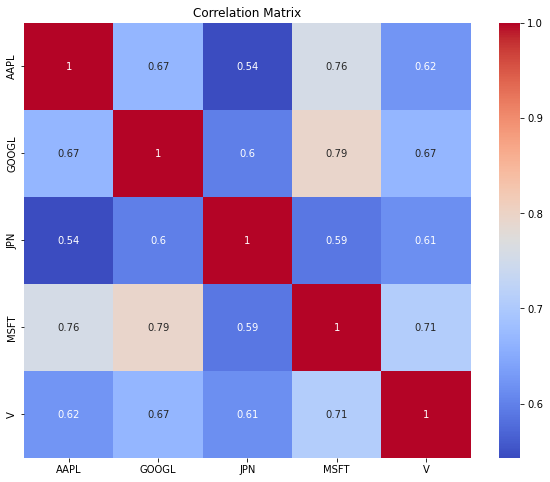

In [159]:
corr_matrix = portfolio_returns['Adj Close'].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [117]:
num_stocks = portfolio_data.shape[1]
np.random.seed(1)
# Weight each security
weights = np.random.random((num_stocks,1))
# normalize it, so that sum is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
log_ret = np.log(portfolio_data / portfolio_data.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')
# Risk-free Rate
risk_free_rate = yf.Ticker('^TNX').history(period='1d', start='2018-01-01', end=None)['Close'].mean() / 100

# Sharpe ratio
sr = (exp_ret - risk_free_rate) / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [2.48391806e-01 4.29048586e-01 6.81253437e-05 1.80079067e-01
 8.74125593e-02 5.49998562e-02]

Expected return of the portfolio is : 0.1585991808404584

Volatility of the portfolio: 0.2786902025238242

Sharpe ratio of the portfolio: 0.4913429093955807


# Monte Carlo Simulation

We basically randomly initialize weights of the securities and check the returns vs risks. And among these set of weights we will find the one, for given risk, which gives the maximum return. However, one can do all this solving optimization problem, using SciPy. 

In [139]:
# number of simulation
n = 10000
# n = 10

port_weights = np.zeros(shape=(n,len(portfolio_data.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

num_securities = len(portfolio_data.columns)
# num_securities
for i in range(n):
    # Weight each security
    weights = np.random.random(num_stocks)
    # normalize it, so that some is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #     print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret
#     print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol
#     print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = exp_ret / exp_vol
    port_sr[i] = sr
#     print(f'\nSharpe ratio : {sr[0][0]}')

In [140]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max SR
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]


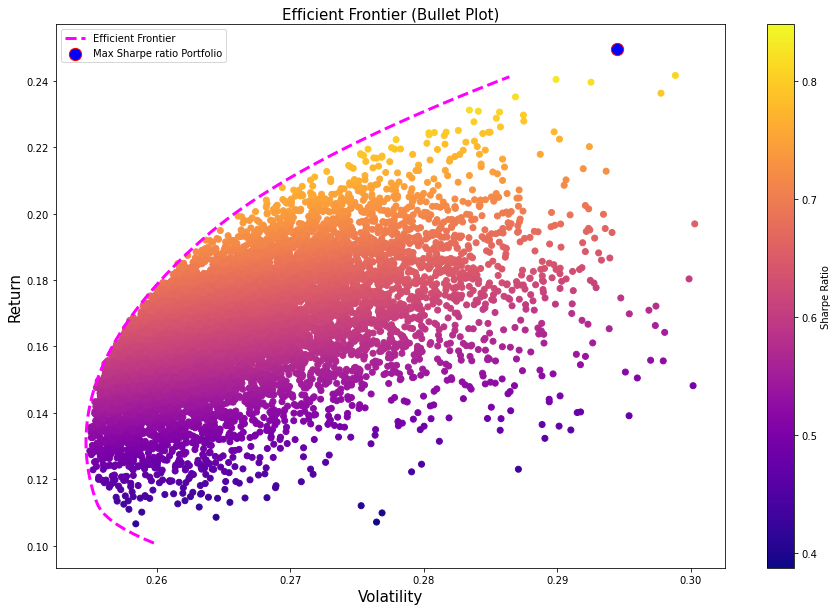

In [141]:
plt.figure(figsize=(15,10))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.plot(frontier_vol, frontier_y, c='magenta', ls='--', lw=3, label='Efficient Frontier')
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();

In [142]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')
    
# best portfolio return
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

54.04 % of AAPL should be bought.
1.16 % of AMZN should be bought.
1.09 % of GOOGL should be bought.
1.04 % of JPM should be bought.
36.88 % of MSFT should be bought.
5.78 % of V should be bought.

Markowitz optimal portfolio return is : 24.96% with volatility 0.2944455714069299
